# Marketing AB Testing 
###### Source: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing 
###### Guideline for running AB testing in general https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing

## Import libraries

In [62]:
import numpy as np
import statistics as st
import datetime as dt
import pandas as pd
from pandas.api.types import CategoricalDtype
from itertools import combinations
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import ttest_ind

## Getting data ready

#### Import data

In [63]:
df_mkt = pd.read_csv(r"C:\Users\Master\Documents\data_analytics\marketing_AB\marketing_AB.csv")

#### Rename columns

In [64]:
df_mkt = df_mkt.rename(columns={"user id": 'user_id', "test group": 'test_group', "total ads" : 'total_ads', "most ads day": 'most_ads_day', "most ads hour" :  'most_ads_hour'})

#### Re-index by ascending values most_ads_hour column 

In [65]:
df_mkt= df_mkt.sort_values(by='most_ads_hour', ascending=True).reset_index(drop=True)
df_mkt.head(20)

,Unnamed: 0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,490821,1460012,ad,False,2,Wednesday,0
1,14249,1007070,ad,False,26,Tuesday,0
2,107636,1345129,ad,True,16,Saturday,0
3,394212,1449048,ad,False,1,Sunday,0
4,14353,1016601,ad,False,39,Friday,0
5,70321,1309281,ad,False,40,Saturday,0
6,404871,1258456,ad,False,14,Wednesday,0
7,121976,1175574,ad,False,15,Sunday,0
8,534780,1127067,ad,False,6,Sunday,0
9,260418,1431776,ad,False,61,Sunday,0


#### Mapping fields using library of 'day' vs 'wk_day_num'

In [66]:
df_day = pd.DataFrame({'day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}) # this way has column name
wk_day_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_day['week_day_number'] = df_day['day'].map(wk_day_num)
df_day['most_ads_day'] = df_day['day']
df_day.head()

,day,week_day_number,most_ads_day
0,Monday,0,Monday
1,Tuesday,1,Tuesday
2,Wednesday,2,Wednesday
3,Thursday,3,Thursday
4,Friday,4,Friday


#### Add week_day_number to df_mkt

In [67]:

df_mkt = pd.merge(df_mkt, df_day[['day', 'week_day_number', 'most_ads_day']], on=['most_ads_day'], how='left')

#### Drop excess or useless columns

In [68]:
df_mkt = df_mkt.drop(columns=["Unnamed: 0", 'day'], axis=1)
df_mkt.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,week_day_number
0,1460012,ad,False,2,Wednesday,0,2
1,1007070,ad,False,26,Tuesday,0,1
2,1345129,ad,True,16,Saturday,0,5
3,1449048,ad,False,1,Sunday,0,6
4,1016601,ad,False,39,Friday,0,4


#### Use where statement to convert False to 0 and True to 1 in col converted

In [69]:
df_mkt['converted']=np.where(df_mkt['converted']==False, 0, 1)
df_mkt.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,week_day_number
0,1460012,ad,0,2,Wednesday,0,2
1,1007070,ad,0,26,Tuesday,0,1
2,1345129,ad,1,16,Saturday,0,5
3,1449048,ad,0,1,Sunday,0,6
4,1016601,ad,0,39,Friday,0,4


In [118]:
df_mkt['most_ads_hour_hr'] = df_mkt['most_ads_hour'].apply(lambda x: f'{x if 1 <= x <= 12 else (12 if x == 0 else x-12)}{"AM" if x < 12 else "PM"}')
df_mkt.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,week_day_number,most_ads_hour_hr,time_block
0,1460012,ad,0,2,Wednesday,0,2,12AM,0200: Wednesday 00hr
1,1007070,ad,0,26,Tuesday,0,1,12AM,0100: Tuesday 00hr
2,1345129,ad,1,16,Saturday,0,5,12AM,0500: Saturday 00hr
3,1449048,ad,0,1,Sunday,0,6,12AM,0600: Sunday 00hr
4,1016601,ad,0,39,Friday,0,4,12AM,0400: Friday 00hr


## My solution

#### Create time blocks

In [71]:
df_mkt['time_block'] = (df_mkt['week_day_number'].astype(str).str.zfill(2) +
                        df_mkt['most_ads_hour'].astype(str).str.zfill(2) +
                        ': ' + df_mkt['most_ads_day'].astype(str) +
                        ' ' + df_mkt['most_ads_hour'].astype(str).str.zfill(2) + 'hr')
df_mkt.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,week_day_number,most_ads_hour_hr,time_block
0,1460012,ad,0,2,Wednesday,0,2,12 AM,0200: Wednesday 00hr
1,1007070,ad,0,26,Tuesday,0,1,12 AM,0100: Tuesday 00hr
2,1345129,ad,1,16,Saturday,0,5,12 AM,0500: Saturday 00hr
3,1449048,ad,0,1,Sunday,0,6,12 AM,0600: Sunday 00hr
4,1016601,ad,0,39,Friday,0,4,12 AM,0400: Friday 00hr


#### Calculate average converstion rates between the groups

In [72]:
df_set = df_mkt.groupby('test_group')['converted'].mean()
print(df_set)

test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


In [73]:
df_c = df_mkt[df_mkt['test_group'] == 'psa']
df_c = df_c.groupby(['week_day_number','most_ads_hour'])['converted'].mean().reset_index()*100
df_c = df_c.rename(columns={'converted': 'control_conversions'})
df_c.head()


,week_day_number,most_ads_hour,control_conversions
0,0,0,0.0
1,0,100,0.0
2,0,200,0.0
3,0,300,0.0
4,0,400,0.0


In [74]:
df_t = df_mkt[df_mkt['test_group'] == 'ad']
df_t = df_t.groupby(['week_day_number','most_ads_hour'])['converted'].mean().reset_index()*100
df_t = df_t.rename(columns={'converted': 'treatment_conversions'})
df_t.head()


,week_day_number,most_ads_hour,treatment_conversions
0,0,0,1.707317
1,0,100,1.694915
2,0,200,0.705219
3,0,300,1.265823
4,0,400,0.000000


In [75]:
print(np.mean(df_c['control_conversions']))
print(np.mean(df_t['treatment_conversions']))

1.3287390913063772
2.284667393948973


### Create AB testing set

In [76]:
df_abset = pd.merge(df_c, df_t[['week_day_number','most_ads_hour','treatment_conversions']], on=['week_day_number','most_ads_hour'], how='inner')
df_abset.head()

,week_day_number,most_ads_hour,control_conversions,treatment_conversions
0,0,0,0.0,1.707317
1,0,100,0.0,1.694915
2,0,200,0.0,0.705219
3,0,300,0.0,1.265823
4,0,400,0.0,0.000000


### A/B testing generic
#### This script calculates the p-value for the Z-score and compares it to the alpha value. If the p-value is less than alpha, we reject the null hypothesis; otherwise, we fail to reject it. You can customize the alpha and number_of_tails parameters to change the confidence level and whether to use a one-tailed or two-tailed test.

In [77]:
def ab_test(control, treatment, alpha, number_of_tails):
    
    control_mean = np.mean(control)
    control_std = np.std(control)
    control_z = (control - np.mean(control)) / np.std(control)
    control_size = len(control)


    treatment_mean = np.mean(treatment)
    treatment_std = np.std(treatment)
    treatment_size = len(treatment)
    treatment_z = (treatment - np.mean(treatment)) / np.std(treatment)
    
    pooled_var = (np.var(control) + np.var(treatment)) / 2
    pooled_se = np.sqrt(pooled_var * (1 / control_size + 1 / treatment_size))
    z_score = (treatment_mean - control_mean) / pooled_se
    p_value = stats.norm.sf(abs(z_score))
    
    x_axis_ann_gap = 0.5
    x = np.linspace(min(control + treatment), max(control + treatment), 1000)
    control_pdf = stats.norm.pdf(x, control_mean, control_std)
    treatment_pdf = stats.norm.pdf(x, treatment_mean, treatment_std)

    
    if number_of_tails == 2:
        p_value *= 2
        critical_value_z = stats.norm.ppf(1 - alpha / 2)
        cv_control = critical_value_z * control_std + control_mean
        cv_treatment = critical_value_z * treatment_std + treatment_mean
        plt.axvline(x=cv_control, color='grey', linestyle='--')
        plt.axvline(x=-cv_control, color='grey', linestyle='--')
        plt.text(cv_control + x_axis_ann_gap, max(control_pdf) * .75, f"{cv_control:.1f}", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
        plt.text(-cv_control + x_axis_ann_gap, 0, f"{-cv_control:.1f}", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
    else:
        critical_value_z = stats.norm.ppf(1 - alpha)
        cv_control = critical_value_z * control_std + control_mean
        cv_treatment = critical_value_z * treatment_std + treatment_mean
        plt.axvline(x=cv_control, color='grey', linestyle='--')
        plt.text(cv_control + x_axis_ann_gap, 0, f"{cv_control:.1f}", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
    if p_value < alpha:
        print(f"Reject null hypothesis (z-score: {z_score:.20f}, p-value: {p_value:.20f})")
    else:
        print(f"Fail to reject null hypothesis (z-score: {z_score:.20f}, p-value: {p_value:.20f})")
    
    plt.plot(x, control_pdf, label='Control', color='red')
    plt.fill_between(x, control_pdf, treatment_pdf, where=(control_pdf > treatment_pdf), facecolor='red', alpha=0.3)

    plt.plot(x, treatment_pdf, label='Treatment', color='green')
    plt.fill_between(x, control_pdf, treatment_pdf, where=(treatment_pdf > control_pdf), facecolor='green', alpha=0.3)

    
    plt.axvline(x=control_mean, color='red', linestyle='--')
    plt.text(control_mean + x_axis_ann_gap, max(control_pdf), f"x̅ c:{control_mean:.1f}", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
    plt.scatter(control_mean, max(control_pdf), color='red')
    
    plt.axvline(x=treatment_mean, color='green', linestyle='--')
    plt.text(treatment_mean + x_axis_ann_gap, max(treatment_pdf), f"x̅ t:{treatment_mean:.1f}", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
    plt.scatter(treatment_mean, max(treatment_pdf), color='green')
    
    plt.text(max(max(treatment), max(control),cv_control) + x_axis_ann_gap, p_value, f"p-value: {p_value:.2f}\n(z-score: {z_score:.1f} )", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.2, edgecolor= 'None'))
    plt.scatter(max(max(treatment),max(control),cv_control), p_value, color='blue')
    plt.legend()
    plt.show()

In [78]:
def z_test(control, treatment, alpha, number_of_tails):
    control_mean = np.mean(control)
    control_std = np.std(control)
    control_size = len(control)

    treatment_mean = np.mean(treatment)
    treatment_std = np.std(treatment)
    treatment_size = len(treatment)

    pooled_var = (np.var(control) + np.var(treatment)) / 2
    pooled_se = np.sqrt(pooled_var * (1 / control_size + 1 / treatment_size))
    z_score = (treatment_mean - control_mean) / pooled_se
    p_value = stats.norm.sf(abs(z_score))

    if number_of_tails == 2:
        p_value *= 2

    if p_value < alpha:
        print(f"Reject null hypothesis (z-score: {z_score:.20f}, p-value: {p_value:.20f})")
    else:
        print(f"Fail to reject null hypothesis (z-score: {z_score:.20f}, p-value: {p_value:.20f})")

In [79]:
def t_test(control, treatment, alpha, number_of_tails):
    t_statistic, p_value = stats.ttest_ind(control, treatment)

    if number_of_tails == 1:
        p_value /= 2

    if p_value < alpha:
        print(f"Reject null hypothesis (t-statistic: {t_statistic:.20f}, p-value: {p_value:.20f})")
    else:
        print(f"Fail to reject null hypothesis (t-statistic: {t_statistic:.20f}, p-value: {p_value:.20f})")

Reject null hypothesis (z-score: 6.73487494109743689563, p-value: 0.00000000001640709903)


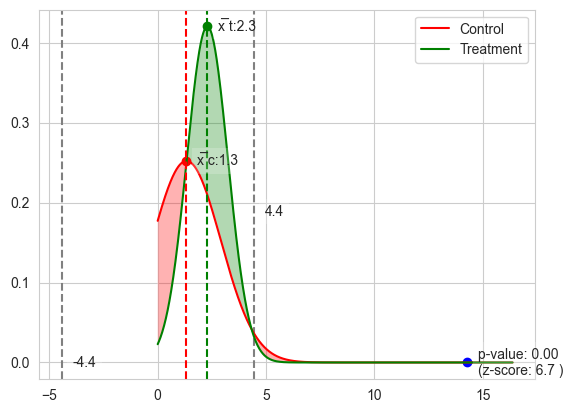

In [80]:
control = df_abset['control_conversions']
treatment = df_abset['treatment_conversions']
alpha = 0.05
number_of_tails = 2
ab_test(control, treatment, alpha, number_of_tails)

In [81]:
t_test(control, treatment, alpha, number_of_tails)

Reject null hypothesis (t-statistic: -6.71468036807727841619, p-value: 0.00000000008180417637)


In [82]:
z_test(control, treatment, alpha, number_of_tails)

Reject null hypothesis (z-score: 6.73487494109743689563, p-value: 0.00000000001640709903)


## https://www.kaggle.com/code/mehmeteryilmazz/marketing-ab-testing

In [83]:
from statsmodels.stats.proportion import proportions_ztest

#### Check underlying data with a defined function

In [84]:
def check_df(dataframe, head=7):
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### Head ####################")
    print(dataframe.head(head))

check_df(df_mkt)

################### Shape ####################
(588101, 9)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           588101 non-null  int64 
 1   test_group        588101 non-null  object
 2   converted         588101 non-null  int32 
 3   total_ads         588101 non-null  int64 
 4   most_ads_day      588101 non-null  object
 5   most_ads_hour     588101 non-null  int64 
 6   week_day_number   588101 non-null  int64 
 7   most_ads_hour_hr  588101 non-null  object
 8   time_block        588101 non-null  object
dtypes: int32(1), int64(4), object(4)
memory usage: 42.6+ MB
None
################### Nunique ###################


user_id             588101
test_group               2
converted                2
total_ads              807
most_ads_day             7
most_ads_hour           24
week_day_number          7
most_ads_hour_hr        24
time_block             168
dtype: int64
##################### NA #####################
user_id             0
test_group          0
converted           0
total_ads           0
most_ads_day        0
most_ads_hour       0
week_day_number     0
most_ads_hour_hr    0
time_block          0
dtype: int64
################## Quantiles #################
                    count          mean            std       min        0%  \
user_id          588101.0  1.310692e+06  202225.983128  900000.0  900000.0   
converted        588101.0  2.523886e-02       0.156850       0.0       0.0   
total_ads        588101.0  2.482088e+01      43.715181       1.0       1.0   
most_ads_hour    588101.0  1.446906e+01       4.834634       0.0       0.0   
week_day_number  588101.0  3.025533e+00       2.0

In [85]:
# Practice loop to count number unique values. confirmed by above
col_df_mkt = df_mkt.columns.tolist()
for x in col_df_mkt:
    unique_values = df_mkt.groupby(x)[x].nunique().sum()
    print(f"{x}: {unique_values}")

user_id: 588101
test_group: 2
converted: 2
total_ads: 807
most_ads_day: 7
most_ads_hour: 24
week_day_number: 7
most_ads_hour_hr: 24
time_block: 168


#### Quick scan

In [86]:
# Practice loop to count number unique values. confirmed by above
col_df_mkt = df_mkt.columns.tolist()
for x in col_df_mkt:
    unique_values = df_mkt.groupby(x)[x].nunique().sum()
    print(f"{x}: {unique_values}")

user_id: 588101
test_group: 2
converted: 2
total_ads: 807
most_ads_day: 7
most_ads_hour: 24
week_day_number: 7
most_ads_hour_hr: 24
time_block: 168


In [87]:
df_mkt.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,week_day_number,most_ads_hour_hr,time_block
0,1460012,ad,0,2,Wednesday,0,2,12 AM,0200: Wednesday 00hr
1,1007070,ad,0,26,Tuesday,0,1,12 AM,0100: Tuesday 00hr
2,1345129,ad,1,16,Saturday,0,5,12 AM,0500: Saturday 00hr
3,1449048,ad,0,1,Sunday,0,6,12 AM,0600: Sunday 00hr
4,1016601,ad,0,39,Friday,0,4,12 AM,0400: Friday 00hr


#### Average conversion rates

In [88]:
df_mkt.groupby('test_group')['converted'].mean()

test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

In [89]:
# We are summing the purchase values separately for those who saw the ad and those who didn't see the ad.
# We assign these to new variables.

ad_converted_count = df_mkt.loc[df_mkt['test_group'] == 'ad', 'converted'].sum()
psa_converted_count = df_mkt.loc[df_mkt['test_group'] == 'psa', 'converted'].sum()


# We are calculating the p-value to determine the effect of seeing, 
# the advertisement on the purchase for those who saw it versus those who didn't see it.

test_stat, pvalue = proportions_ztest(count=[ad_converted_count, psa_converted_count],
                                      nobs=[df_mkt.loc[df_mkt['test_group'] == 'ad' , 'converted'].shape[0],
                                            df_mkt.loc[df_mkt['test_group'] == 'psa', 'converted'].shape[0]])

# count = success count
# nobs = the total number of observations
# Thus, we obtain the ratio.


print(f"{test_stat}, {pvalue}")

7.3700781265454145, 1.7052807161559727e-13


## To replicate above with:
##### ab_test(), t_test(), z_test()

In [90]:
df_ad =  (df_mkt[df_mkt['test_group'] == 'ad'])['converted']
df_ad.info()

<class 'pandas.core.series.Series'>
Int64Index: 564577 entries, 0 to 588100
Series name: converted
Non-Null Count   Dtype
--------------   -----
564577 non-null  int32
dtypes: int32(1)
memory usage: 6.5 MB


In [91]:
df_psa =  (df_mkt[df_mkt['test_group'] == 'psa'])['converted']
df_psa.info()

<class 'pandas.core.series.Series'>
Int64Index: 23524 entries, 37 to 588093
Series name: converted
Non-Null Count  Dtype
--------------  -----
23524 non-null  int32
dtypes: int32(1)
memory usage: 275.7 KB


Reject null hypothesis (z-score: 7.93666950889004940706, p-value: 0.00000000000000207682)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


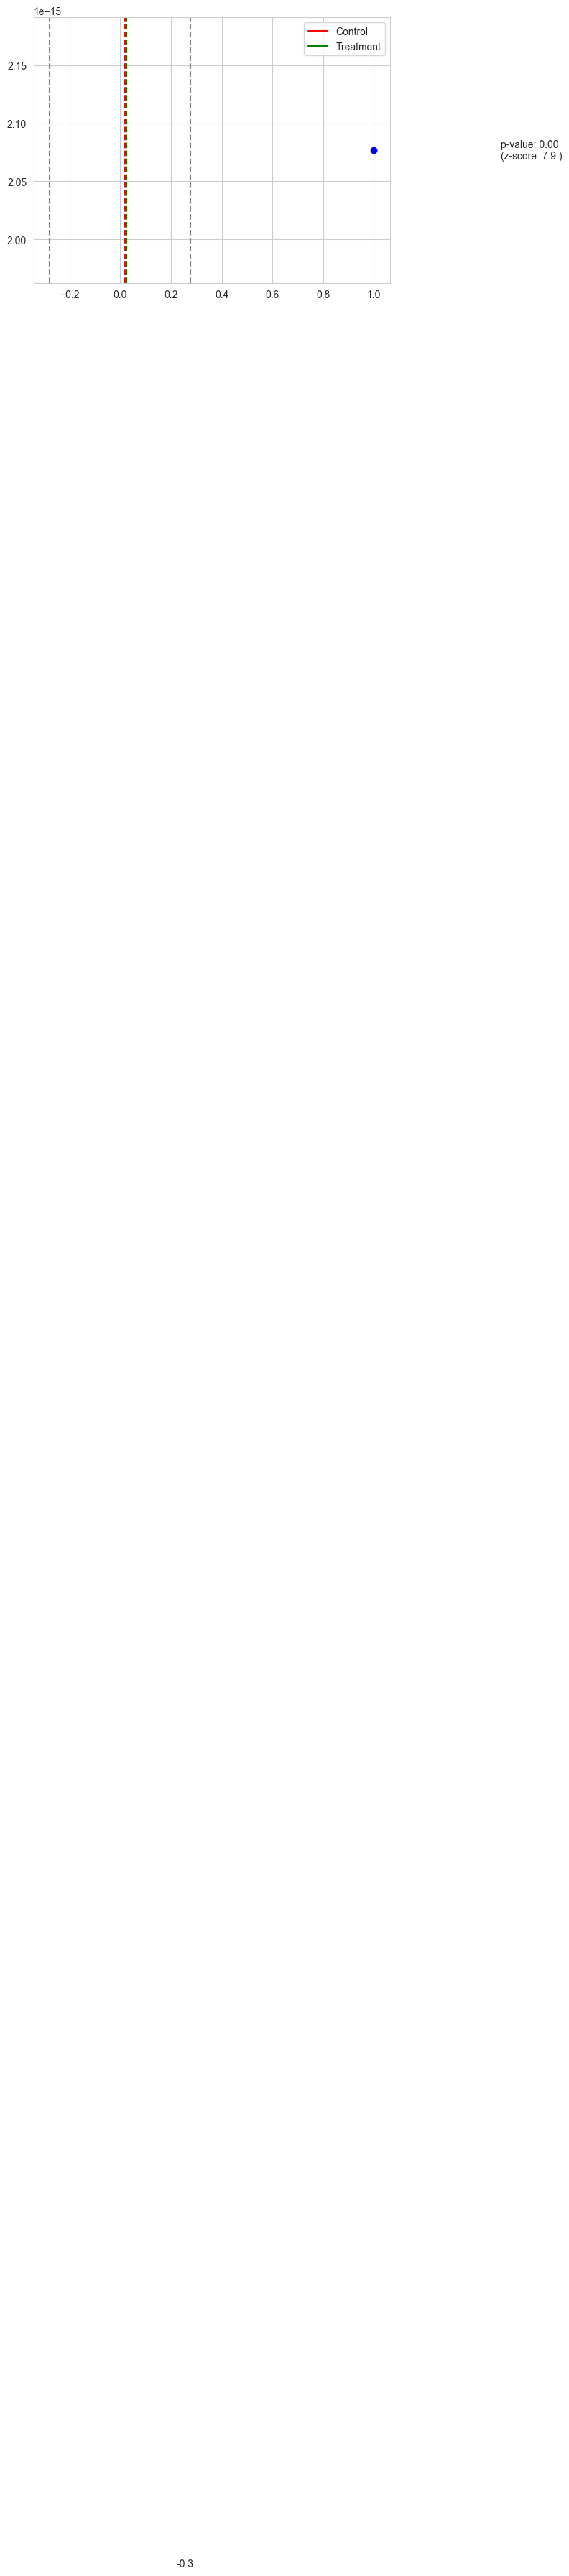

In [92]:
ab_test(df_psa, df_ad, alpha, number_of_tails)

In [93]:
t_test(df_psa, df_ad, alpha, number_of_tails)

Reject null hypothesis (t-statistic: -7.37040597428565824600, p-value: 0.00000000000017033053)


In [94]:
z_test(df_psa, df_ad, alpha, number_of_tails)

Reject null hypothesis (z-score: 7.93666950889004940706, p-value: 0.00000000000000207682)


## https://www.kaggle.com/code/pratul007/a-b-testing-best-solution

In [95]:
print(df_mkt.head()) # View the first few rows of the dataset
df_mkt.info() # Get information about the data types and number of non-null values in each column
df_mkt.describe() # Get summary statistics for numeric columns
df_mkt.isnull().sum() # Check for missing values

   user_id test_group  converted  total_ads most_ads_day  most_ads_hour  \
0  1460012         ad          0          2    Wednesday              0   
1  1007070         ad          0         26      Tuesday              0   
2  1345129         ad          1         16     Saturday              0   
3  1449048         ad          0          1       Sunday              0   
4  1016601         ad          0         39       Friday              0   

   week_day_number most_ads_hour_hr            time_block  
0                2            12 AM  0200: Wednesday 00hr  
1                1            12 AM    0100: Tuesday 00hr  
2                5            12 AM   0500: Saturday 00hr  
3                6            12 AM     0600: Sunday 00hr  
4                4            12 AM     0400: Friday 00hr  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            ---------

user_id             0
test_group          0
converted           0
total_ads           0
most_ads_day        0
most_ads_hour       0
week_day_number     0
most_ads_hour_hr    0
time_block          0
dtype: int64

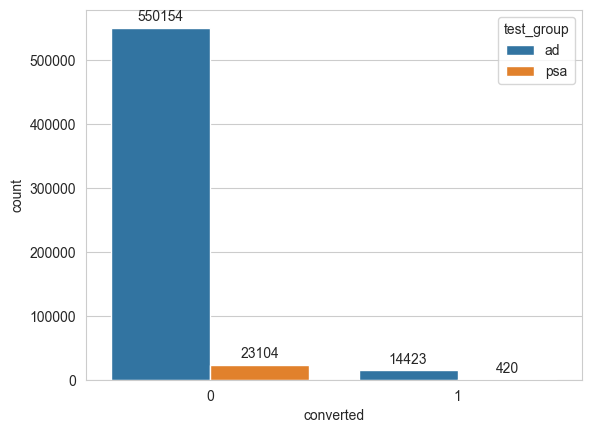

In [96]:
ax = sns.countplot(x='converted', hue='test_group', data=df_mkt)

# Get the counts for each bar
counts = df_mkt.groupby(['test_group', 'converted']).size().reset_index(name='count')

# Add text to each bar
for i, bar in enumerate(ax.containers):
    for j, count in enumerate(bar):
        height = count.get_height()
        ax.annotate(counts.iloc[i*2+j]['count'], xy=(count.get_x() + count.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")


In [97]:
ttest_results = ttest_ind(df_mkt[df_mkt['test_group'] == 'ad']['converted'], df_mkt[df_mkt['test_group'] == 'psa']['converted'])
print(ttest_results)

Ttest_indResult(statistic=7.370405974285658, pvalue=1.703305262783145e-13)


In [98]:
conversion_rates = df_mkt.groupby('test_group')['converted'].mean()
print(conversion_rates)

test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


###### The statistic value of 7.37 represents the t-statistic for the test. This value indicates that there is a significant difference between the means of the two groups being compared.
###### The pvalue value of 1.70e-13 represents the probability of observing a t-statistic at least as extreme as the observed value, assuming that there is no difference between the means of the two groups being compared (i.e., assuming the null hypothesis). This value is very small, which suggests strong evidence against the null hypothesis and in favor of the alternative hypothesis (i.e., that there is a significant difference between the means of the two groups).
###### Taken together, these results suggest that there is a significant difference between the means of the two groups being compared, and that this difference is unlikely to have occurred by chance alone.
##### Based on these conversion rates, we can interpret that the ad group had a higher conversion rate (0.025547) compared to the PSA group (0.017854). This suggests that the ads were effective in driving conversions and that the ad campaign was successful.

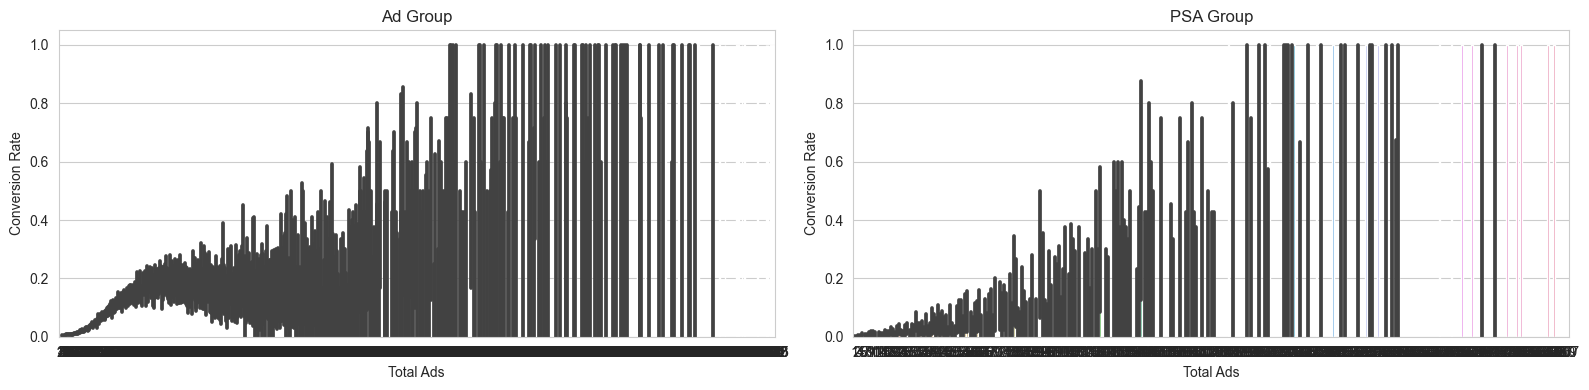

In [99]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))

sns.barplot(x='total_ads', y='converted', data=df_mkt[df_mkt['test_group'] == 'ad'], ax=ax[0])
ax[0].set(title="Ad Group", xlabel="Total Ads", ylabel="Conversion Rate")

sns.barplot(x='total_ads', y='converted', data=df_mkt[df_mkt['test_group'] == 'psa'], ax=ax[1])
ax[1].set(title="PSA Group", xlabel="Total Ads", ylabel="Conversion Rate")

plt.tight_layout()
plt.show()

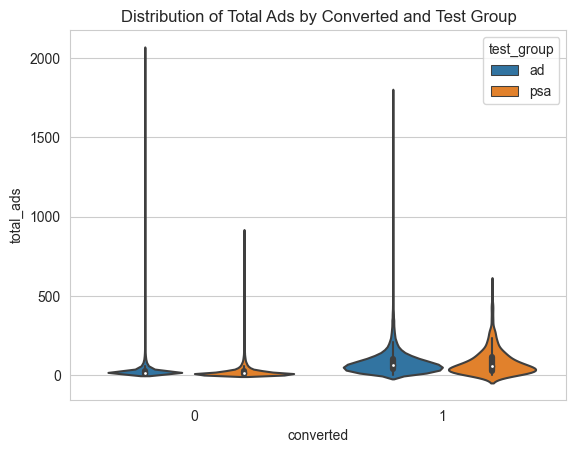

In [100]:
sns.violinplot(x='converted', y='total_ads', hue='test_group', data=df_mkt)
plt.title("Distribution of Total Ads by Converted and Test Group")
plt.xlabel('converted')
plt.ylabel('total_ads')
plt.show()

<Axes: xlabel='most_ads_day', ylabel='converted'>

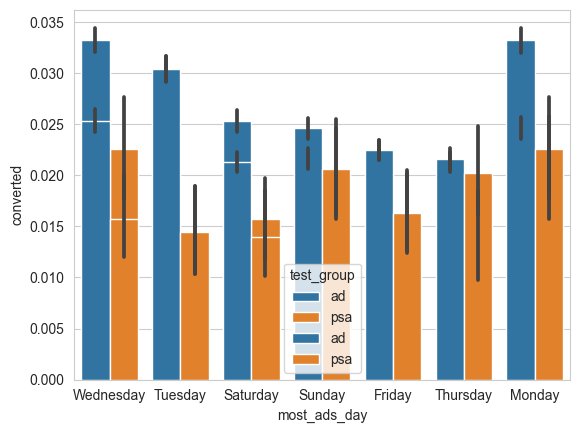

In [101]:
sns.barplot(x='most_ads_day', y='converted', hue='test_group', data=df_mkt, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.barplot(x='most_ads_day', y='converted', hue='test_group', data=df_mkt)

In [102]:
# Group the data by most ads hour, and calculate the mean of the converted column
conversion_by_hour = df_mkt.groupby('most_ads_hour')['converted'].mean()

# Find the hour with the highest conversion rate
max_conversion_hour = conversion_by_hour.idxmax()

# Print the result
print("The hour of the day with the highest conversion rate was:", max_conversion_hour)

The hour of the day with the highest conversion rate was: 16


In [103]:
# Calculate conversion rate by day and test group
conversion_by_day = df_mkt.groupby(['most_ads_day', 'test_group'])["converted"].mean()

# Reshape the data from long to wide format
conversion_by_day = conversion_by_day.unstack(level=1)

# Sort the values in descending order
conversion_by_day = conversion_by_day.sort_values(by=["ad", "psa"], ascending=False)

# Print the result
print(conversion_by_day)

test_group          ad       psa
most_ads_day                    
Monday        0.033241  0.022559
Tuesday       0.030440  0.014448
Wednesday     0.025356  0.015759
Sunday        0.024620  0.020595
Friday        0.022465  0.016303
Thursday      0.021637  0.020230
Saturday      0.021307  0.013996


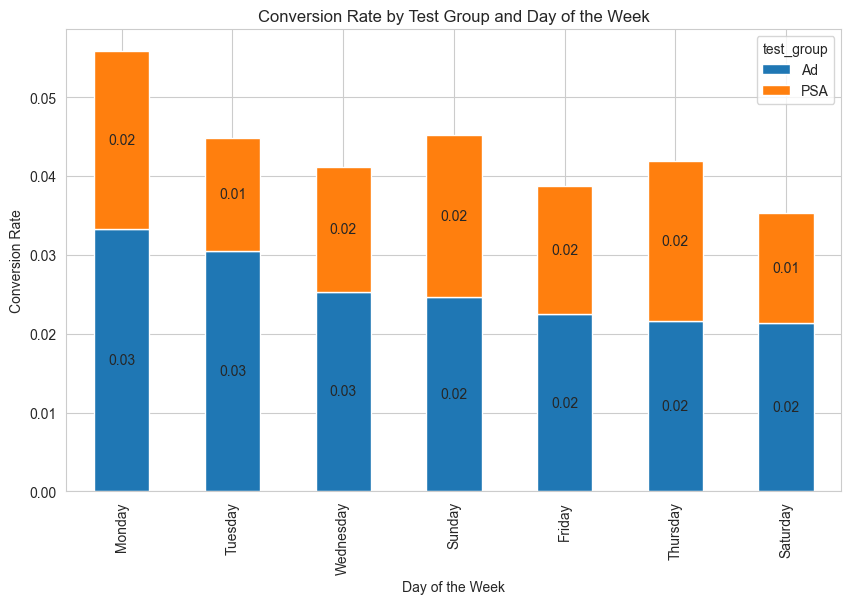

In [104]:
# Sort the values in descending order
conversion_by_day = conversion_by_day.sort_values(by=['ad', 'psa'], ascending=False)

# Create a stacked bar plot of the conversion rate by day and test group
sns.set_style("whitegrid")
ax = conversion_by_day.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Conversion Rate by Test Group and Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Conversion Rate")

# Add value labels to each bar segment
for i in range(conversion_by_day.shape[0]):
    ad_value = conversion_by_day.iloc[i]['ad']
    psa_value = conversion_by_day.iloc[i]['psa']
    ax.text(i, ad_value / 2, f"{ad_value:.2f}", ha="center", va="center")
    ax.text(i, ad_value + psa_value / 2, f"{psa_value:.2f}", ha="center", va="center")

plt.legend(title='test_group', labels=["Ad", "PSA"])
plt.show()

In [119]:
# Group the data by most ads hour and calculate the mean of the converted column
conversion_by_hour = df_mkt.groupby('most_ads_hour')['converted'].mean()

# Sort the values in ascending order and take the top 10
top_10_less_business_hours = conversion_by_hour.sort_values().head(10)

# Print the result
print("Top 10 hours with less business:")
print(top_10_less_business_hours)

Top 10 hours with less business:
most_ads_hour
2     0.007313
3     0.010452
1     0.012911
4     0.015235
7     0.018111
0     0.018425
9     0.019191
8     0.019516
5     0.020915
10    0.021521
Name: converted, dtype: float64


In [122]:
hr_order=['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']

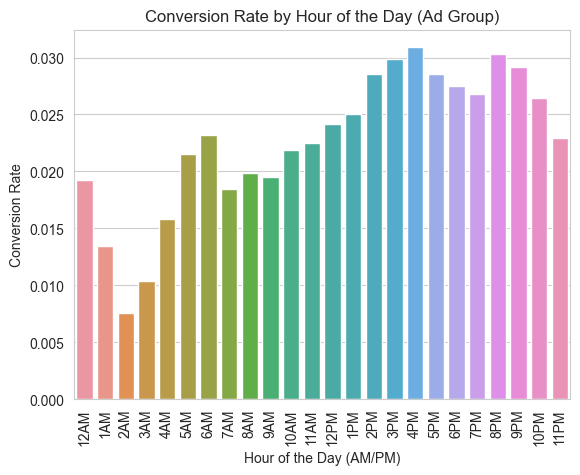

In [123]:
# Filter the data to include only the "ad" group 
df_ad = df_mkt[df_mkt['test_group'] == 'ad'] 
# Group the data by hour of the day, and calculate the mean of the converted column 
conversion_by_hour = df_ad.groupby('most_ads_hour_hr')['converted'].mean().reset_index() 
# Create a bar plot of the conversion rate by hour of the day 
sns.barplot(data=conversion_by_hour, x=conversion_by_hour['most_ads_hour_hr'], y='converted', order=hr_order) 
plt.title("Conversion Rate by Hour of the Day (Ad Group)") 
plt.xlabel("Hour of the Day (AM/PM)") 
plt.ylabel("Conversion Rate") 
# Rotate the x-axis labels by 45 degrees 
plt.xticks(rotation=90) 
plt.show()

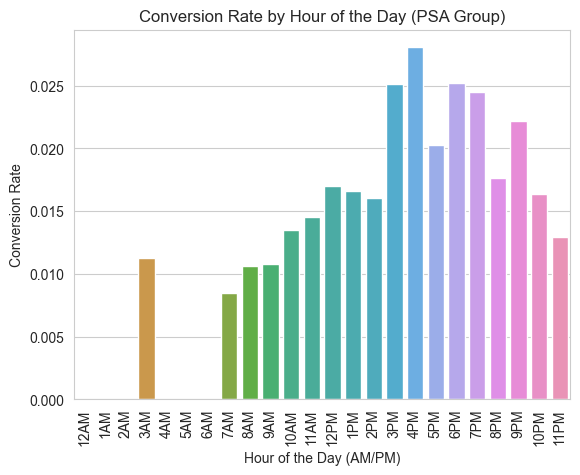

In [124]:
# Filter the data to include only the "psa" group 
df_psa = df_mkt[df_mkt['test_group'] == 'psa'] 
# Group the data by hour of the day, and calculate the mean of the converted column 
conversion_by_hour_psa = df_psa.groupby('most_ads_hour_hr')['converted'].mean().reset_index() 
# Create a bar plot of the conversion rate by hour of the day 
sns.barplot(data=conversion_by_hour_psa, x=conversion_by_hour_psa['most_ads_hour_hr'], y='converted', order=hr_order) 
plt.title("Conversion Rate by Hour of the Day (PSA Group)") 
plt.xlabel("Hour of the Day (AM/PM)") 
plt.ylabel("Conversion Rate") 
# Rotate the x-axis labels by 45 degrees 
plt.xticks(rotation=90) 
plt.show()

In [108]:
df_mkt['most_ads_hour_hr']

0         12 AM
1         12 AM
2         12 AM
3         12 AM
4         12 AM
          ...  
588096    11 PM
588097    11 PM
588098    11 PM
588099    11 PM
588100    11 PM
Name: most_ads_hour_hr, Length: 588101, dtype: object

In [ ]:
print("The conversion rate for the ad group is {:.2f}%".format(conversion_rates['ad'] * 100))
print("The conversion rate for the PSA group is {:.2f}%".format(conversion_rates['psa'] * 100))
print("The t-test p-value is {:.4f}".format(ttest_results.pvalue))

The conversion rate for the ad group is 2.55%
The conversion rate for the PSA group is 1.79%
The t-test p-value is 0.0000
